In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy

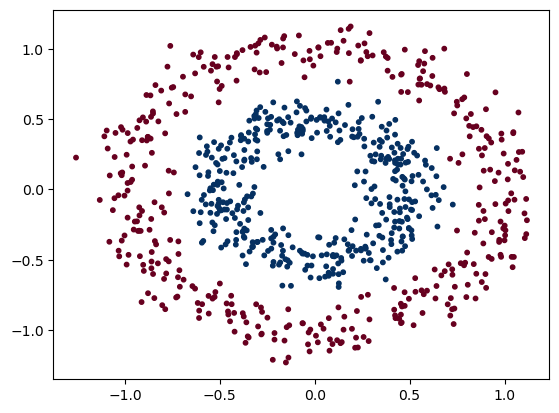

In [10]:
# Create a circles dataset
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Plot data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

In [11]:
model = nn.Sequential(
    nn.Linear(2, 6),
    nn.ReLU(),
    nn.Linear(6, 7),
    nn.ReLU(),
    nn.Linear(7, 7),
    nn.ReLU(),
    nn.Linear(7, 7),
    nn.ReLU(),
    nn.Linear(7, 2),
    nn.Sigmoid()
)

print(model)
model_cpy = copy.deepcopy(model)

Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=7, bias=True)
  (5): ReLU()
  (6): Linear(in_features=7, out_features=7, bias=True)
  (7): ReLU()
  (8): Linear(in_features=7, out_features=2, bias=True)
  (9): Sigmoid()
)


In [12]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.3989, Val Loss: 0.4112
Epoch [200/1000], Loss: 0.3516, Val Loss: 0.3663
Epoch [300/1000], Loss: 0.3360, Val Loss: 0.3518
Epoch [400/1000], Loss: 0.3286, Val Loss: 0.3451
Epoch [500/1000], Loss: 0.3244, Val Loss: 0.3412
Epoch [600/1000], Loss: 0.3217, Val Loss: 0.3388
Epoch [700/1000], Loss: 0.3199, Val Loss: 0.3380
Epoch [800/1000], Loss: 0.3186, Val Loss: 0.3377
Epoch [900/1000], Loss: 0.3177, Val Loss: 0.3365
Epoch [1000/1000], Loss: 0.3170, Val Loss: 0.3354


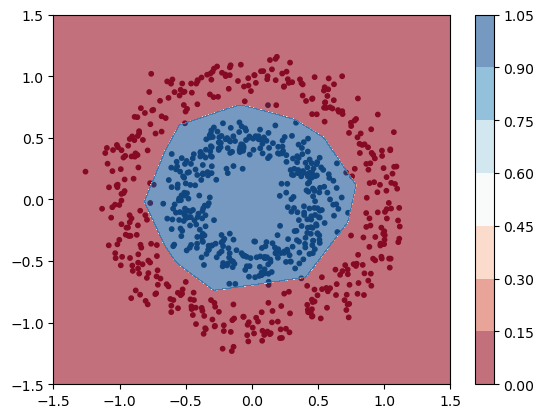

In [20]:
# Decision boundary for dataset
x = torch.linspace(-1.5, 1.5, 1000)
y = torch.linspace(-1.5, 1.5, 1000)
xv, yv = torch.meshgrid(x, y)

# Reshape xv and yv
xv = xv.reshape(-1)
yv = yv.reshape(-1)

# Stack xv and yv into a tensor
grid = torch.stack((xv, yv), dim=1)
# Feed the grid tensor into the model

model.eval()
with torch.no_grad():
    outputs = model(grid)
    
# Get the predicted class
_, y_pred = torch.max(outputs, 1)

# Plot the prediction grid as an image
# plt.imshow(y_pred.reshape(1000, 1000), origin='lower', extent=(-1.5, 1.5, -1.5, 1.5), alpha=0.3)

# Plot the original data and color it according to the classes
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

# Plot the decision boundary
plt.contourf(x, y, y_pred.reshape(1000, 1000), alpha=0.6, cmap=plt.cm.RdBu)
plt.colorbar()
plt.show()

In [25]:
# torch.unique(model(X_val_tensor))
y_val_outputs = model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.98

In [ ]:
def add_layer(pruned_layers, input_shape, output_shape, layer_data):
	layer = nn.Linear(input_shape, output_shape)
	with torch.no_grad():
		layer.data = layer_data
	pruned_layers.append(layer)
	pruned_layers.append(nn.ReLU())

def get_layers_not_pruned(prune_ratio, param):
	sorted_layers = torch.linalg.norm(param.data, ord=1, dim=1).argsort(dim=-1)
	return sorted(sorted_layers[int(prune_ratio*param.data.shape[0]):])

def prune_one_shot(prune_ratio, model):
	prune_ratio = 0.4
	pruned_model = nn.Sequential()
	pruned_layers = []
	input_layers = torch.tensor([0,1])
	layer_index = 0

	for name, param in model.named_parameters():
		if 'weight' in name:
			if param.shape[0] == 2:
				add_layer(pruned_layers, input_layers.shape, 2, model_cpy[layer_index].weight.data)
				continue

			layers_not_pruned = get_layers_not_pruned(prune_ratio, param)
			
			#initialising unpruned neurons with pre-trainied values
			layer_data = model_cpy[layer_index].weight.data[layers_not_pruned, input_layers]

			add_layer(pruned_layers, input_layers.shape, layer_data.shape[0], layer_data)

			layer_index=layer_index+2	#skipping every alternate relu layer

	print(pruned_layers)
	pruned_model = nn.Sequential(*pruned_layers)
	print(pruned_model[0].data)
    

In [6]:
model = nn.Sequential(
    nn.Linear(2, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
	nn.ReLU(),
    nn.Linear(3, 2),
    nn.Sigmoid()
)

Epoch [100/1000], Loss: 0.5430, Val Loss: 0.5689
Epoch [200/1000], Loss: 0.3654, Val Loss: 0.3905
Epoch [300/1000], Loss: 0.3409, Val Loss: 0.3653
Epoch [400/1000], Loss: 0.3326, Val Loss: 0.3560
Epoch [500/1000], Loss: 0.3286, Val Loss: 0.3513
Epoch [600/1000], Loss: 0.3262, Val Loss: 0.3485
Epoch [700/1000], Loss: 0.3245, Val Loss: 0.3464
Epoch [800/1000], Loss: 0.3233, Val Loss: 0.3448
Epoch [900/1000], Loss: 0.3222, Val Loss: 0.3438
Epoch [1000/1000], Loss: 0.3214, Val Loss: 0.3428


0.975

In [ ]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# torch.unique(model(X_val_tensor))
y_val_outputs = model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

In [8]:
for name, param in model.named_parameters():
	if param.requires_grad:
		print(param)

Parameter containing:
tensor([[-4.0897, -1.2217],
        [-0.8814, -3.4095],
        [ 2.6866, -3.2367]], requires_grad=True)
Parameter containing:
tensor([-0.3131,  3.0044, -0.0283], requires_grad=True)
Parameter containing:
tensor([[ 0.1503, -0.0566,  0.2044],
        [ 2.7568, -0.4295,  2.5964],
        [ 3.2160, -3.4650,  2.9835]], requires_grad=True)
Parameter containing:
tensor([-0.5512, -4.3609,  3.4356], requires_grad=True)
Parameter containing:
tensor([[-0.2677,  3.8342,  3.8134],
        [ 0.2491, -3.7295, -3.8214]], requires_grad=True)
Parameter containing:
tensor([-5.1377,  5.1453], requires_grad=True)


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.init as init
import numpy as np
import copy
import matplotlib.animation as animation
from matplotlib.animation import ImageMagickWriter

In [50]:
# Defining Accuracy
def calculate_accuracy(model, X, y):
    with torch.no_grad():
        outputs = model(X)
        predictions = outputs.argmax(dim=-1)
        accuracy = (predictions == y).sum().item() / len(y)
    return accuracy

# Training loop
def train(model,X_train_tensor, X_val_tensor,y_train_tensor, y_val_tensor, epochs = 100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor)
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


In [51]:

# Plot decision boundary
def plot_decision_boundary(model, ax):
    x = torch.linspace(-1.5, 1.5, 1000)
    y = torch.linspace(-1.5, 1.5, 1000)
    xv, yv = torch.meshgrid(x, y)

    # Reshape xv and yv
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)

    # Stack xv and yv into a tensor
    grid = torch.stack((xv, yv), dim=1)
    # Feed the grid tensor into the model

    model.eval()
    with torch.no_grad():
        outputs = model(grid)
        
    # Get the predicted class
    _, y_pred = torch.max(outputs, 1)

    # Plot the prediction grid as an image
    # ax.imshow(y_pred.reshape(1000, 1000), origin='lower', extent=(-1.5, 1.5, -1.5, 1.5), alpha=0.3)

    # Plot the original data and color it according to the classes
    scat = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

    # Set the ticks and ticklabels for the axes
    # ax.set_xticks([-1, 0, 1])
    # ax.set_yticks([-1, 0, 1])
    # ax.set_xticklabels([-1, 0, 1])
    # ax.set_yticklabels([-1, 0, 1])

    # # Plot the decision boundary
    cont = ax.contourf(x, y, y_pred.reshape(1000, 1000), alpha=0.5, cmap=plt.cm.RdBu)
    # colbar = ax.colorbar()

    return cont
    # plt.show()


# model

In [52]:

# Create a circles dataset
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Plot data
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

# Defining the model
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 18),
    nn.ReLU(),
    nn.Linear(18, 16),
    nn.ReLU(),
    nn.Linear(16, 14),
    nn.ReLU(),
    nn.Linear(14, 2),
    nn.Sigmoid()
)

# Copying the initial wieghts of the model
pre_training_model = copy.deepcopy(model)

# One-shotPrune the model

# In this method, we prune prune_ratio fatures in each layer
# The nn.Sequential method randomly initialises when called
def oneshot_pruning( post_training_model, input_shape, output_shape, prune_ratio = 0.2):
    unpruned_layers = [] 
    layer_index = 0
    layers_pruned = []
    for name, param in post_training_model.named_parameters():
        if 'weight' in name:
            # Not pruning the last output layer
            if param.shape[0] == output_shape:
                layer = nn.Linear(input_shape, output_shape)
                with torch.no_grad():
                    layer.data = post_training_model[layer_index].weight.data[:, [col for col in range(param.data.shape[1]) if col not in layers_pruned]]
                unpruned_layers.append(layer)
                unpruned_layers.append(nn.Sigmoid())
                continue
            # Sorting the features in a layer based on l1 norm
            param_with_skipped_input = post_training_model[layer_index].weight.data[:, [col for col in range(param.data.shape[1]) if col not in layers_pruned]]
            sorted_layers = torch.linalg.norm(param_with_skipped_input, ord=1, dim=1).argsort(dim=-1)
            layers_not_pruned = sorted(sorted_layers[int(prune_ratio*param_with_skipped_input.shape[0]):])
            layers_pruned = sorted(sorted_layers[:int(prune_ratio*param_with_skipped_input.shape[0])])

            # Initialising unpruned neurons with pre-training values
            layer_data = param_with_skipped_input[layers_not_pruned, :] 
            layer = nn.Linear(input_shape, layer_data.shape[0])
            input_shape = layer_data.shape[0]
            with torch.no_grad():
                layer.data = layer_data
            unpruned_layers.append(layer)
            unpruned_layers.append(nn.ReLU())
            #skipping every alternate relu layer
            layer_index=layer_index+2
    return nn.Sequential(*unpruned_layers)  

# In this method of one-shot structured re-initialsed pruning,
# We prune pm fatures in each layer based on L1 norm, and remove pruned layers outgoing edge
# The nn.Sequential method randomly initialises when called 
# So we copy the initial values of pre_training_model using indexing
def oneshot_pruning_reinit( post_training_model, pre_training_model, input_shape, output_shape, prune_ratio = 0.2):
    unpruned_layers = [] 
    layer_index = 0
    layers_pruned = []
    for name, param in post_training_model.named_parameters():
        if 'weight' in name:
            # Not pruning the last output layer
            if param.shape[0] == output_shape:
                layer = nn.Linear(input_shape, output_shape)
                with torch.no_grad():
                    layer.data = pre_training_model[layer_index].weight.data[:, [col for col in range(param.data.shape[1]) if col not in layers_pruned]]
                unpruned_layers.append(layer)
                unpruned_layers.append(nn.Sigmoid())
                continue
            # Sorting the features in a layer based on l1 norm
            param_with_skipped_input = pre_training_model[layer_index].weight.data[:, [col for col in range(param.data.shape[1]) if col not in layers_pruned]]
            sorted_layers = torch.linalg.norm(param_with_skipped_input, ord=1, dim=1).argsort(dim=-1)
            layers_not_pruned = sorted(sorted_layers[int(prune_ratio*param_with_skipped_input.shape[0]):])
            layers_pruned = sorted(sorted_layers[:int(prune_ratio*param_with_skipped_input.shape[0])])

            # Initialising unpruned neurons with pre-training values
            layer_data = param_with_skipped_input[layers_not_pruned, :] 
            layer = nn.Linear(input_shape, layer_data.shape[0])
            input_shape = layer_data.shape[0]
            with torch.no_grad():
                layer.data = layer_data
            unpruned_layers.append(layer)
            unpruned_layers.append(nn.ReLU())
            #skipping every alternate relu layer
            layer_index=layer_index+2
    model = nn.Sequential(*unpruned_layers)
    index = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            param.data = unpruned_layers[index].data
            index=index+2
    return model
            


In [53]:

#Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train(model,X_train_tensor,X_val_tensor, y_train_tensor, y_val_tensor, epochs = 100)
torch.save(model.state_dict(), 'trained_model.pickle')
unpruned_accuracy = calculate_accuracy(model, X_val_tensor, y_val_tensor)

# Plot Accuracy vs Pruning Ratio
pruning_ratios = np.linspace(0.1, 0.9, 5)
itr_pruning_accuracies = []
oneshot_pruning_reinit_accuracies = []
oneshot_pruning_accuracies = []
nonreinitialised_oneshot_pruning_accuracies = []


Epoch [10/100], Loss: 0.6704, Val Loss: 0.6696
Epoch [20/100], Loss: 0.5465, Val Loss: 0.5481
Epoch [30/100], Loss: 0.4236, Val Loss: 0.4305
Epoch [40/100], Loss: 0.3372, Val Loss: 0.3499
Epoch [50/100], Loss: 0.3174, Val Loss: 0.3401
Epoch [60/100], Loss: 0.3155, Val Loss: 0.3372
Epoch [70/100], Loss: 0.3148, Val Loss: 0.3355
Epoch [80/100], Loss: 0.3144, Val Loss: 0.3345
Epoch [90/100], Loss: 0.3141, Val Loss: 0.3343
Epoch [100/100], Loss: 0.3140, Val Loss: 0.3341


# train

MovieWriter imagemagick unavailable; using Pillow instead.


Epoch [10/100], Loss: 0.6904, Val Loss: 0.6898
Epoch [20/100], Loss: 0.6628, Val Loss: 0.6611
Epoch [30/100], Loss: 0.5297, Val Loss: 0.5250
Epoch [40/100], Loss: 0.3637, Val Loss: 0.3714
Epoch [50/100], Loss: 0.3204, Val Loss: 0.3346
Epoch [60/100], Loss: 0.3161, Val Loss: 0.3386
Epoch [70/100], Loss: 0.3152, Val Loss: 0.3386
Epoch [80/100], Loss: 0.3147, Val Loss: 0.3356
Epoch [90/100], Loss: 0.3145, Val Loss: 0.3352
Epoch [100/100], Loss: 0.3143, Val Loss: 0.3349
Epoch [10/100], Loss: 0.6680, Val Loss: 0.6641
Epoch [20/100], Loss: 0.5224, Val Loss: 0.5132
Epoch [30/100], Loss: 0.3374, Val Loss: 0.3516
Epoch [40/100], Loss: 0.3173, Val Loss: 0.3401
Epoch [50/100], Loss: 0.3153, Val Loss: 0.3399
Epoch [60/100], Loss: 0.3145, Val Loss: 0.3366
Epoch [70/100], Loss: 0.3142, Val Loss: 0.3364
Epoch [80/100], Loss: 0.3140, Val Loss: 0.3367
Epoch [90/100], Loss: 0.3139, Val Loss: 0.3371
Epoch [100/100], Loss: 0.3138, Val Loss: 0.3372
Epoch [10/100], Loss: 0.6901, Val Loss: 0.6895
Epoch [20/1

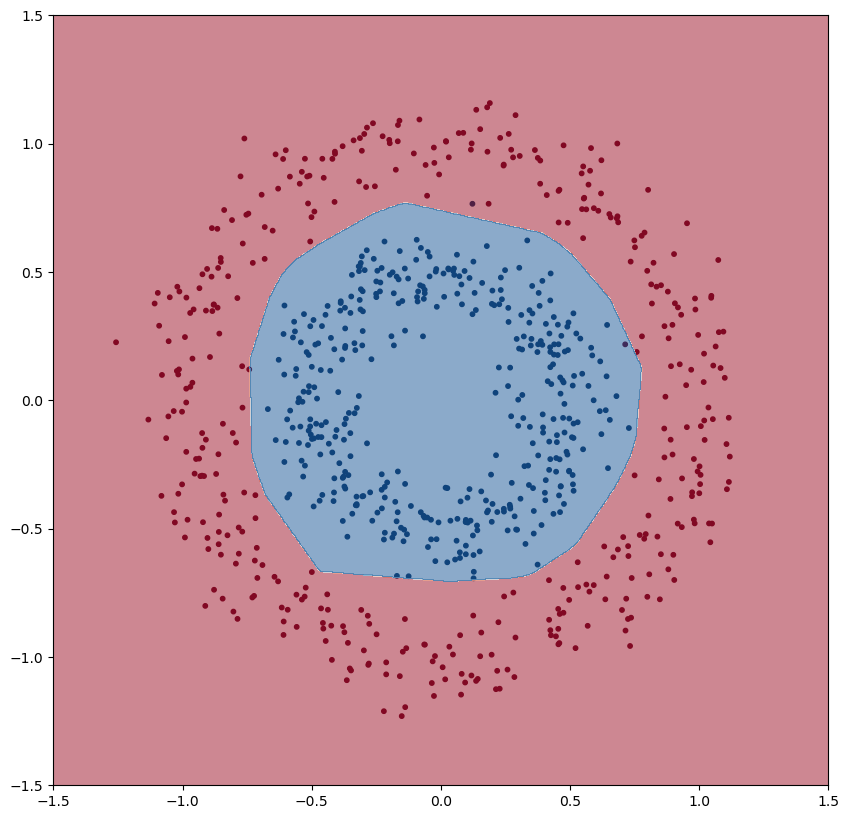

In [55]:

# animating decision boundary for each pruning ratio
fig, axs = plt.subplots(figsize=(10, 10))
artist = []


def animate(i):
    prune_ratio = pruning_ratios[i]
    # pre_training_model_cpy = copy.deepcopy(pre_training_model)

    # one-shot pruning
    oneshot_pruned_model = oneshot_pruning(model, input_shape = 2, output_shape = 2, prune_ratio = prune_ratio)
    train(oneshot_pruned_model,X_train_tensor,X_val_tensor, y_train_tensor, y_val_tensor, epochs = 100)
    accuracy = calculate_accuracy(oneshot_pruned_model, X_val_tensor, y_val_tensor)
    oneshot_pruning_accuracies.append(accuracy)

    axs.clear()
    return plot_decision_boundary(oneshot_pruned_model, axs)

    # re-initiliased one-shot pruning, pre_training_model_cpy gets pruned and udpated
    # oneshot_reinitialised_pruned_model = oneshot_pruning_reinit(model,pre_training_model_cpy, input_shape = 2, output_shape = 2, prune_ratio = prune_ratio)
    # train(oneshot_reinitialised_pruned_model,X_train_tensor,X_val_tensor, y_train_tensor, y_val_tensor, epochs = 100)
    # accuracy = calculate_accuracy(oneshot_reinitialised_pruned_model, X_val_tensor, y_val_tensor)
    # oneshot_pruning_reinit_accuracies.append(accuracy)

# fig.colorbar(artist[0][1], ax=axs)
# ani = animation.ArtistAnimation(fig, artist, interval=100, blit=True)
ani = animation.FuncAnimation(fig, animate, frames=5, interval=300)
ani.save('oneshot_pruning.gif', writer='imagemagick' )


In [ ]:

plt.axhline(y = unpruned_accuracy, color = 'b', linestyle = '--')
plt.plot(pruning_ratios, oneshot_pruning_accuracies, marker='x')
plt.plot(pruning_ratios, oneshot_pruning_reinit_accuracies, marker='o')
plt.legend(["No pruning","One-shot","Re-init One-shot"], loc ="lower right")
plt.title("Accuracy vs. Pruning Ratio")
plt.xlabel("Pruning Ratio")
plt.ylabel("Accuracy")
plt.grid()
plt.savefig('oneshot_acc_vs_pm.png')
plt.show()

In [61]:
import glob

from PIL import Image


def make_gif(frame_folder, filename):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(f"{filename}.gif", format="GIF", append_images=frames,save_all=True, duration=400, loop=1)
    

make_gif("oneshot_pruned_model", "img/oneshot_pruned_model")
make_gif("oneshot_reinitialised_pruned_model", "img/oneshot_reinitialised_pruned_model")

In [5]:
import glob
sorted(glob.glob("oneshot_pruned_model/*.png"))

['oneshot_pruned_model/1.0.png',
 'oneshot_pruned_model/1.4.png',
 'oneshot_pruned_model/1.8.png',
 'oneshot_pruned_model/2.2.png',
 'oneshot_pruned_model/2.6.png',
 'oneshot_pruned_model/3.1.png',
 'oneshot_pruned_model/3.5.png',
 'oneshot_pruned_model/3.9.png',
 'oneshot_pruned_model/4.3.png',
 'oneshot_pruned_model/4.7.png',
 'oneshot_pruned_model/5.2.png',
 'oneshot_pruned_model/5.6.png',
 'oneshot_pruned_model/6.0.png',
 'oneshot_pruned_model/6.4.png',
 'oneshot_pruned_model/6.8.png',
 'oneshot_pruned_model/7.3.png',
 'oneshot_pruned_model/7.7.png',
 'oneshot_pruned_model/8.1.png',
 'oneshot_pruned_model/8.5.png',
 'oneshot_pruned_model/9.0.png']